Project 1 - Portfolio Risk Analysis (annotated)

Goal of this project is to demonstrate how to measure portfolio risk using historical and simulated stock data. We will compute returns, volatility, correlations, Value at Risk (VaR), Expected Shortfall (ES), and backtest the model. This notebook keeps the original code intact; explanations below show the mathematics and the Python mechanics for each block.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest

- `yfinance`: to download stock data
- `pandas` and `numpy`: for data manipulation and numerical work
- `matplotlib` and `seaborn`: for plotting
- `scipy.stats`: for statistical backtesting (binomial test)

In [3]:
tickers = ["AAPL","MSFT","AMZN","JPM","XOM","TSLA"]
start = "2022-01-01"
end = "2024-12-31"

data = yf.download(tickers, start=start, end=end)
df = data['Close']          # just the closing prices
df = df.dropna()            # clean missing values

C:\Users\Jacon\AppData\Local\Temp\ipykernel_21976\3077162835.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  6 of 6 completed


### Downloading and Cleaning Price Data

- `yf.download(tickers, start, end)` pulls historical stock data (Open, High, Low, Close, Volume) for our tickers.  
- We select only the **closing prices** (`data['Close']`) since they’re the standard reference for return calculations.  
- `dropna()` removes rows with missing values so all tickers are aligned on the same dates.  

In [4]:
returns = np.log(df / df.shift(1)).dropna()
trading_days = 252

# annualised mean and vol
mean_daily = returns.mean()
cov_daily = returns.cov()

mu_annual = mean_daily * trading_days
cov_annual = cov_daily * trading_days
vol_annual = np.sqrt(np.diag(cov_annual))

# cumulative returns
cumulative = (1 + returns).cumprod()

## Daily & Annualised Returns

### Math
- **Log returns:**  
  Daily log return is  
  $$
  r_t = \ln\!\left(\frac{P_t}{P_{t-1}}\right),
  $$
  where $P_t$ is today’s price.  
  - Advantage: log returns **add up** over time (unlike arithmetic returns).  
  - This means cumulative growth is simply  
    $$
    \exp\!\Big(\sum_{s=1}^t r_s\Big).
    $$

- **Annualisation:**  
  Markets trade about $N=252$ days per year.  
  - Annual mean return:
    $$
    \mu_{\text{annual}} = N \cdot \bar r_{\text{daily}}
    $$
  - Annual covariance:
    $$
    \Sigma_{\text{annual}} = N \cdot \Sigma_{\text{daily}}
    $$
  - Annual volatility for asset $i$:
    $$
    \sigma_i = \sqrt{(\Sigma_{\text{annual}})_{ii}}
    $$

### Python
 

- `vol_annual = np.sqrt(np.diag(cov_annual))`  
  → extracts the diagonal of the covariance matrix (variances of each asset), then takes square roots to get volatilities.  

- `cumulative = np.exp(returns.cumsum())`  
  → builds a time series of cumulative wealth from log returns: starting with \$1, this shows how much it would grow if reinvested each day.

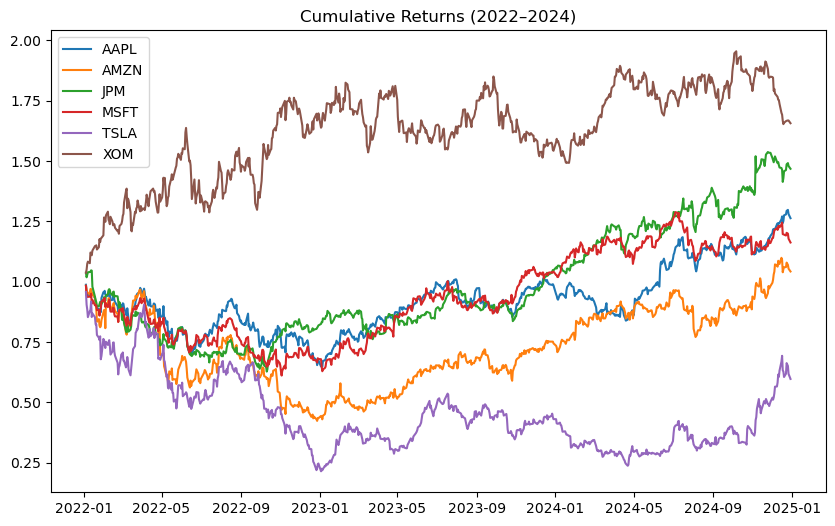

In [5]:
plt.figure(figsize=(10,6))
for c in cumulative.columns:
    plt.plot(cumulative.index, cumulative[c], label=c)

plt.title("Cumulative Returns (2022–2024)")
plt.legend()
plt.show()

## Plotting Cumulative Returns

### Math
- The cumulative return series shows the **growth of \$1 invested** over time.  
- If $r_t$ are daily log returns, then the value at time $T$ is
  $$
  V_T = \exp\!\Big(\sum_{t=1}^T r_t\Big).
  $$
- Plotting $V_t$ for each stock lets us visually compare performance across the investment horizon (2022–2024).

### Python
  - Loop: `plt.plot(cumulative.index, cumulative[c], label=c)` For each stock, we plot `cumulative.index` (dates on the x-axis) and `cumulative[c]` which is that stock's cumulative return series (y-axis). 

Annualised Sharpe Ratios:
 Ticker
AAPL    0.424578
AMZN    0.228560
JPM     0.640733
MSFT    0.320937
TSLA    0.023470
XOM     0.758105
dtype: float64


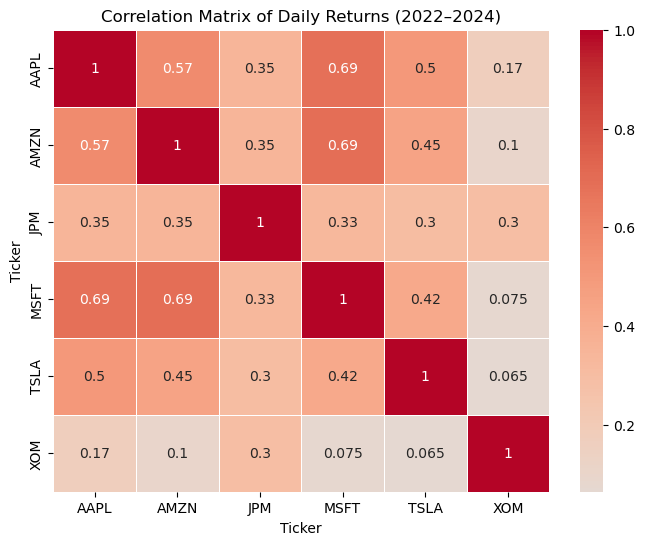

In [6]:
# Sharpe ratio (assuming r_f = 0 for now)
sharpe_ratios = mu_annual / vol_annual
print("Annualised Sharpe Ratios:\n", sharpe_ratios)

# correlation of daily returns
corr = returns.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns (2022–2024)")
plt.show()


**Sharpe Ratio (risk-adjusted return):**

The Sharpe ratio measures how much return an asset provides per unit of risk (volatility):

$$
Sharpe_i = \frac{\mu_i - r_f}{\sigma_i}
$$

- Here $r_f = 0$, so it simplifies to $Sharpe_i = \mu_i / \sigma_i$  
- $\mu_i$: annualised expected return of stock $i$  
- $\sigma_i$: annualised volatility of stock $i$  
- Higher Sharpe ratio = better risk-adjusted performance.  

In Python:
- `mu_annual / vol_annual` gives a Sharpe ratio per ticker.  

**Correlation Matrix (dependence between stocks):**

Correlation shows how assets move together:

- $\rho_{ij} \approx 1$: stocks move in the same direction.  
- $\rho_{ij} \approx 0$: little or no relation.  
- $\rho_{ij} \approx -1$: move in opposite directions.  

This helps identify diversification opportunities (low or negative correlations).

In [7]:
VaR_hist = returns.quantile(0.05, axis=0)

print("Historical 95% Daily VaR:")
print(VaR_hist)

n_sims = 100000

VaR_mc = {}

for ticker in returns.columns:
    mu = mean_daily[ticker]
    sigma = returns[ticker].std()

    # Simulate n_sims returns from Normal(mu, sigma)
    sims = np.random.normal(mu, sigma, n_sims)

    # Monte Carlo VaR = 5th percentile of simulated returns
    VaR_mc[ticker] = np.percentile(sims, 100*0.05)

VaR_mc = pd.Series(VaR_mc)
print("Monte Carlo 95% Daily VaR:")
print(VaR_mc)

tickers = returns.columns.tolist()
n = len(tickers)

Historical 95% Daily VaR:
Ticker
AAPL   -0.027573
AMZN   -0.037070
JPM    -0.025090
MSFT   -0.027871
TSLA   -0.065298
XOM    -0.027975
Name: 0.05, dtype: float64
Monte Carlo 95% Daily VaR:
AAPL   -0.027463
AMZN   -0.039405
JPM    -0.025294
MSFT   -0.028291
TSLA   -0.063633
XOM    -0.027574
dtype: float64


### Value-at-Risk (VaR)

**1. Historical VaR:**

- VaR measures the **maximum expected loss** at a given confidence level over a certain period. For the 5% (95% confidence) daily VaR, we look at the **5th percentile** of historical returns
### Python
`VaR_mc = {} ` Creates an empty dictionary to store Monte Carlo VaR results. `for ticker in returns.columns:  ` loops over each stock in the returns DataFrame and obtains `mu` (mean) and `sigma` (std). `sims = np.random.normal(mu, sigma, n_sims) `  simulates n_sims daily returns from a normal distribution with mean mu and standard deviation sigma. `VaR_mc[ticker] = np.percentile(sims, 100*0.05)`computes the 5th percentile of the simulated returns for this stock and stores it in the dictionary as the Monte Carlo VaR.
`VaR_mc = pd.Series(VaR_mc)` converts the dictionary of Monte Carlo VaR values into a Pandas Series for easier handling. `tickers = returns.columns.tolist()  ` extracts the column names from the returns DataFrame (these are the stock tickers) and converts them into a Python list.




In [8]:
# 1) Choose portfolio weights (example: equal weight)
w = np.array([1.0/n]*n)

# 2) Historical portfolio returns & Historical VaR (daily)
port_hist = returns.dot(w)                     # historical portfolio daily returns
VaR_hist = np.percentile(port_hist, 100 * 0.05)  # e.g. 5th percentile (negative number)

# 3) Monte Carlo: simulate correlated daily returns
# Use Cholesky of cov_daily
cov = cov_daily.values if isinstance(cov_daily, pd.DataFrame) else cov_daily
mu = mean_daily.values
L = np.linalg.cholesky(cov)

Z = np.random.normal(size=(n_sims, n))
sim_returns = Z.dot(L.T) + mu  # each row = simulated daily returns for assets
sim_port = sim_returns.dot(w)  # simulated portfolio returns

VaR_mc = np.percentile(sim_port, 100 * 0.05)

### Portfolio VaR (Historical and Monte Carlo)

**1) Choose portfolio weights (example: equal weight)**
`w = np.array([1.0/n]*n)`  Creates an array of portfolio weights. Each stock gets an equal share: 1 divided by the number of assets `n`.  
  
**2) Historical portfolio returns & Historical VaR (daily)**
`port_hist = returns.dot(w)` Computes daily portfolio returns by taking a **weighted sum** of asset returns. Uses the dot product: each day’s return = sum of (stock return × weight).  

`VaR_hist = np.percentile(port_hist, 100 * 0.05)` Calculates the 5th percentile of portfolio returns. This is the **Historical Value-at-Risk**: the daily loss threshold not exceeded 95% of the time. It will usually be a negative number (a loss).  

**3) Monte Carlo: simulate correlated daily returns**
`cov = cov_daily.values if isinstance(cov_daily, pd.DataFrame) else cov_daily ` Ensures the covariance matrix is in NumPy array format (needed for matrix operations).  

`mu = mean_daily.values`  Extracts the mean daily returns of all assets as a NumPy array.  

`L = np.linalg.cholesky(cov)` Performs a **Cholesky decomposition** of the covariance matrix which creates a lower-triangular matrix `L` that captures correlations between assets.  

`Z = np.random.normal(size=(n_sims, n))` Generates random numbers from a standard normal distribution. Shape is (100,000 simulations × number of assets).  

`sim_returns = Z.dot(L.T) + mu` Transforms independent random numbers into **correlated simulated returns**. Each row is one simulated scenario of daily returns for all assets.  

`sim_port = sim_returns.dot(w)`  
- Combines the simulated asset returns into portfolio returns, using the same weights `w`.  

`VaR_mc = np.percentile(sim_port, 100 * 0.05)` 
- Takes the 5th percentile of simulated portfolio returns.  
- This is the **Monte Carlo Value-at-Risk**, which accounts for both volatility and correlations.  


In [9]:
# 4) Expected Shortfall (Average loss in worst alpha fraction)
ES_hist = port_hist[port_hist <= VaR_hist].mean()
ES_mc = sim_port[sim_port <= VaR_mc].mean()

# 5) Backtest: count exceedances of historical dataset
exceedances = (port_hist <= VaR_mc).sum()     # how many historical days fell below simulated VaR
n_obs = len(port_hist)
obs_rate = exceedances / n_obs

# Binomial test (Kupiec-style idea): null = exceedance probability = 0.05
bt = binomtest(k=exceedances, n=n_obs, p=0.05)
p_value = bt.pvalue

###  Expected Shortfall (ES) and Backtest

Expected Shortfall (also called Conditional VaR) measures the **average loss given that losses are worse than VaR**.  
Formally, at confidence level $\alpha=5\%$:

$$
ES_\alpha = \mathbb{E}[R \mid R \leq \text{VaR}_\alpha]
$$
VaR backtesting checks how often actual losses exceed the model’s VaR estimate. We count the number of exceedancess and produce an observation rate: `obs_rate = exceedances / n_obs ` . If the model is calibrated correctly, this should be close to $5\%$.

###  Kupiec Binomial Test 
To formally test calibration, we use the **Kupiec Binomial Test**.  
The null hypothesis is that the exceedance probability equals $0.05$.  

Mathematically, the number of exceedances $X$ follows a binomial distribution:

$$
X \sim \text{Binomial}(n_{\text{obs}}, 0.05)
$$

From this, we compute a $p$-value:  

- If $p < 0.05$: reject the null → the observed exceedance rate is statistically different from 5%, so the VaR model fails the test.  
- If $p \geq 0.05$: fail to reject → exceedances are consistent with a 5% risk model, so the VaR model passes.  

In other words, the test checks whether our risk model is *honest* about tail risk. A good model should not underestimate or overestimate the frequency of extreme losses.



In [10]:
# === 6) Print results ===
print("Portfolio weights:", dict(zip(tickers, np.round(w,3))))
print(f"N historical days = {n_obs}")
print(f"Historical VaR (daily, {100*(1-0.05):.0f}% conf) = {VaR_hist:.4%}")
print(f"Monte Carlo VaR (daily, {100*(1-0.05):.0f}% conf)  = {VaR_mc:.4%}")
print(f"Historical ES (avg loss | loss <= VaR_hist) = {ES_hist:.4%}")
print(f"Monte Carlo ES = {ES_mc:.4%}")
print(f"Observed exceedances vs expected: {exceedances} observed, expected ~ {0.05*n_obs:.1f}")
print(f"Observed exceedance rate = {obs_rate:.3%}")
print(f"Binomial test p-value (H0: exceedance rate = {0.05}) = {p_value:.3f}")

# Quick interpretation helper
if p_value < 0.05:
    print("=> Backtest FAILS at 5% level: model exceedance rate statistically different from 0.05.")
else:
    print("=> Backtest PASSES: exceedance rate consistent with 0.05 (no statistical rejection).")

Portfolio weights: {'AAPL': 0.167, 'AMZN': 0.167, 'JPM': 0.167, 'MSFT': 0.167, 'TSLA': 0.167, 'XOM': 0.167}
N historical days = 751
Historical VaR (daily, 95% conf) = -2.5126%
Monte Carlo VaR (daily, 95% conf)  = -2.4256%
Historical ES (avg loss | loss <= VaR_hist) = -3.4786%
Monte Carlo ES = -3.0511%
Observed exceedances vs expected: 45 observed, expected ~ 37.6
Observed exceedance rate = 5.992%
Binomial test p-value (H0: exceedance rate = 0.05) = 0.209
=> Backtest PASSES: exceedance rate consistent with 0.05 (no statistical rejection).


### Results Interpretation  

- **Portfolio weights**: Each of the 6 stocks (AAPL, AMZN, JPM, MSFT, TSLA, XOM) is equally weighted at ~16.7%.  
- **Historical VaR (95%) = -2.51%** → Based on past data, the portfolio is expected to lose no more than 2.51% on 95% of days.  
- **Monte Carlo VaR (95%) = -2.43%** → Simulation under the normal model gives a very similar result, suggesting consistency between historical and model-based methods.  
- **Historical ES = -3.48%** → On the worst 5% of days, the *average loss* is 3.48%.  
- **Monte Carlo ES = -3.05%** → The simulated tail losses are slightly less severe, but still close to historical estimates.  
- **Exceedances**: 45 days in the historical record were worse than the Monte Carlo VaR. The model expected about 37.6 days ($751 \times 5\%$).  
- **Observed exceedance rate = 5.99%** → This is a little higher than the target 5%, but close enough.  
- **Binomial test $p$-value = 0.209** → Since $p > 0.05$, we fail to reject the null hypothesis that the true exceedance probability is 5%.  

---

### Conclusion  

The backtest **passes**: the observed exceedances are statistically consistent with the 5% confidence level.  
This means the VaR model is a reasonable approximation of portfolio downside risk in this sample.